In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### PROJECT AIM:
#### 1. Building a ML model from scratch where it takes: Title, Location, Duration(Months), Skills the user has, Perks the user needs to return a monthly stipend estimate.
#### 2. Productionise the model using flask API and host it online.

In [2]:
df = pd.read_excel("internshala_scraped_raw.xls")
df.head(3)

,Title,Company,Location,Duration,Stipend,Apply By,Applicants,Skills Required,Perks,Number of Openings,Link
0,Fundraising,Tare Zameen Foundation,Work From Home,1 Month,1000 /month + Incentives,18 Feb' 22,390 applicants,NaN,"Certificate , Letter of recommendation , Flexi...",200.0,https://internshala.com/internship/detail/fund...
1,Business Development,Internshala,Gurgaon,6 Months,20000 /month,22 Feb' 22,346 applicants,"MS-Office ,","Certificate , Informal dress code , 5 days a w...",2.0,https://internshala.com/internship/detail/busi...
2,Campus Ambassador,International Model United Nations,Work From Home,1 Month,Performance Based,2 Mar' 22,654 applicants,NaN,"Certificate , Letter of recommendation , Flexi...",3000.0,https://internshala.com/internship/detail/camp...


### Fix stipend:

In [3]:
#added incentives column (1 if incentives or performance based in stipend)
df["Incentives"] = df["Stipend"].apply(lambda x: 1 if "Incentives" in x or "Performance Based" in x else 0)

In [4]:
#removed incentives from stipend
df["Stipend"] = df["Stipend"].str.replace("  Incentives", "")

In [5]:
#removed performance based and replaced with 0
df["Stipend"] = df["Stipend"].str.replace("Performance Based", "0")

In [6]:
#replaced unpaid with 0
df["Stipend"] = df["Stipend"].str.replace("Unpaid", "0")

In [7]:
#replaced not provided with 0
df["Stipend"] = df["Stipend"].str.replace("Not provided", "0")

In [8]:
#added separate column for lumpsum amount to do calculations of per month
df["Lumpsum"] = df["Stipend"].apply(lambda x: x.split("lump sum")[0] if "lump sum" in x else 0)

In [9]:
#removed word lump sum from stipend
df["Stipend"] = df["Stipend"].str.replace("lump sum", "")

In [10]:
#added separate column for weekly amount to do calculation of per month
df["Weekly"] = df["Stipend"].apply(lambda x: x.split("/week")[0] if "/week" in x else 0)

In [11]:
#removed word week from stipend
df["Stipend"] = df["Stipend"].str.replace("/week","")

In [12]:
#added separate column for per design amount to do calculation of per month
df["Design"] = df["Stipend"].apply(lambda x: x.split("/Design")[0] if "/Design" in x else 0)

In [13]:
#removed the word design from stipend
df["Stipend"] = df["Stipend"].str.replace("/Design", "")

In [14]:
#removed the word month from stipend
df["Stipend"] = df["Stipend"].str.replace("/month", "")

In [15]:
#removed the symbol "+" from stipend
df["Stipend"] = df["Stipend"].str.replace("+", "")

In [16]:
#striped blank spaces from stipend to do calculations w/o exceptions
df["Stipend"] = df["Stipend"].str.strip()

In [17]:
#averaged the stipend for range values
df["Stipend"] = df["Stipend"].apply(lambda x: (int(x.split("-")[0]) + int(x.split("-")[1]))/2 if "-" in x else x)

In [18]:
#replaced not provided duration to 0 (will take the average going ahead)
df["Duration"] = df["Duration"].str.replace("Not Provided","0")

In [19]:
#made duration monthly column to store conversions in month for further calculations
df["Duration in Month"] = df["Duration"].apply(lambda x: x.split(" ")[0] if "Month" in x else float(x.split(" ")[0].strip()) / 4.345)

In [20]:
#averaged ranged lumpsum values
df["Lumpsum"] = df["Lumpsum"].apply(lambda x: (int(x.split("-")[0]) + int(x.split("-")[1]))/2 if "-" in str(x) else x)

In [21]:
#converted to float for ease in calculations
df["Duration in Month"] = df["Duration in Month"].astype("float")
df["Lumpsum"] = df["Lumpsum"].astype("float")

In [22]:
#divided lumpsum by monthly duration to get montly amount
df["Lumpsum to monthly"] = (df["Lumpsum"]) / (df["Duration in Month"])


In [23]:
#averaged ranged weekly values
df["Weekly"] = df["Weekly"].apply(lambda x: (int(x.split("-")[0]) + int(x.split("-")[1]))/2 if "-" in str(x) else x)

In [24]:
#converted to float for ease in further calculations
df["Weekly"] = df["Weekly"].astype("float")

In [25]:
#converted weekly amount to monthly
df["Weekly to monthly"] = df["Weekly"] * 4.345

In [26]:
#converted design amount to monthly
df["Design to monthly"] = df["Design"].apply(lambda x: int(x) * 30 if x != 0 else 0)

In [27]:
#converted stipend to float for ease in calculations
df["Stipend"] = df["Stipend"].astype("float")

In [28]:
#pipeline calc converting stipend to final
df["Stipend monthly"] = df.apply(lambda x: x["Stipend"] if x["Lumpsum to monthly"] == 0 else x["Lumpsum to monthly"], axis=1)

In [29]:
#pipeline calc converting stipend to final
df["Stipend monthly2"] = df.apply(lambda x: x["Stipend monthly"] if x["Weekly to monthly"] == 0 else x["Weekly to monthly"], axis=1)

In [30]:
#pipeline calc converting stipend to final
df["Stipend monthly final"] = df.apply(lambda x: x["Stipend monthly2"] if x["Design to monthly"] == 0 else x["Design to monthly"], axis=1)

In [31]:
#storing stipend monthly final calculated back to stipend
df["Stipend"] = df["Stipend monthly final"]

In [32]:
#dropping all unneccesary columns made above
df.drop(['Duration', 'Lumpsum to monthly', 'Weekly to monthly', 'Design to monthly', 'Stipend monthly', 'Stipend monthly2', 'Stipend monthly final', 'Lumpsum', 'Weekly', 'Design', 'Number of Openings', 'Link', 'Apply By', 'Applicants'], axis=1, inplace=True)

### Fix skills reqd.:

In [33]:
#checking for null values
df.isnull().sum()

Title                   0
Company                 0
Location                0
Stipend                 2
Skills Required      3482
Perks                 913
Incentives              0
Duration in Month       0
dtype: int64

In [34]:
#filled null values in skills required
df["Skills Required"].fillna("Not Specific , ", axis=0, inplace=True)

In [35]:
#created list with all specific skills required for each row
df["Skills Required"] = df["Skills Required"].apply(lambda x: x.split(" , ")[:-1])

In [36]:
#got the unique names with for loop of all unique skills for further calculations
m_list = []
for i in df["Skills Required"]:
    m_list += i
skill_name_list = []
for i in m_list:
    if i not in skill_name_list:
        skill_name_list.append(i)
    else:
        skill_name_list = skill_name_list

In [37]:
#created dummy columns of specific skills for ML modelling coming ahead
for i in skill_name_list:
    df[i] = i
    for j in range(0,15119):
        if df[i][j] in df["Skills Required"][j]:
            df[i][j] = 1
        else:
            df[i][j] = 0

In [38]:
#saved a copy to df1 to reduce loading and processing times
df1 = df.copy()

In [39]:
#dropped unneeded columns
df1.drop(["Not Specific", "Skills Required"], axis=1, inplace=True)

### Fixing Perks:

In [40]:
#filled null values in perks
df1["Perks"].fillna("Not Specific , ", axis=0, inplace=True)

In [41]:
#created list with all specific perk for each row
df1["Perks"] = df1["Perks"].apply(lambda x: x.split(" , ")[:-1])

In [42]:
#got the unique names with for loop of all unique perks for further calculations
m_list = []
for i in df1["Perks"]:
    m_list += i
perk_name_list = []
for i in m_list:
    if i not in perk_name_list:
        perk_name_list.append(i)
    else:
        perk_name_list = perk_name_list
print(perk_name_list)

['Certificate', 'Letter of recommendation', 'Flexible work hours', 'Informal dress code', '5 days a week', 'Job offer', 'Not Specific', 'Free snacks & beverages']


In [43]:
#created dummy columns of specific perks for ML modelling coming ahead
for i in perk_name_list:
    df1[i] = i
    for j in range(0,15119):
        if df1[i][j] in df1["Perks"][j]:
            df1[i][j] = 1
        else:
            df1[i][j] = 0

In [44]:
#dropped unneeded columns
df1.drop(["Perks", "Not Specific"], axis=1, inplace=True)

In [45]:
#two rows with incomplete info accross all columns so will drop them
df1[df1["Duration in Month"] == 0]

,Title,Company,Location,Stipend,Incentives,Duration in Month,MS-Office,Creative Writing,Event Management,Report Writing,...,InterPlanetary File System,SharePoint,COMSOL,Certificate,Letter of recommendation,Flexible work hours,Informal dress code,5 days a week,Job offer,Free snacks & beverages
15112,Cost Accounting,Oil & Natural Gas Corporation Limited,Agartala,NaN,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15114,Volunteering,Centre For Science And Environment (CSE),Delhi,NaN,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#dropped the 2 rows
df1.drop([15112, 15114], axis=0, inplace=True)

In [47]:
#removed outliers that can affect our ML models and also to normalise our target variable distribution as much as possible
df1 = df1[(df1["Stipend"] <=df1["Stipend"].quantile(0.9)) & (df1["Stipend"] >=df1["Stipend"].quantile(0.1))]

### Basic EDA just to get an overview: 

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Relinns Technologies'),
  Text(1, 0, 'Webtechage Private Limited'),
  Text(2, 0, 'Stirring Minds'),
  Text(3, 0, 'Reach Technologies'),
  Text(4, 0, 'Multibhashi'),
  Text(5, 0, 'MyMegaminds'),
  Text(6, 0, 'OneService India'),
  Text(7, 0, 'AstroTalk'),
  Text(8, 0, 'Medicana'),
  Text(9, 0, 'DeepThought Edutech Ventures Private Limited')])

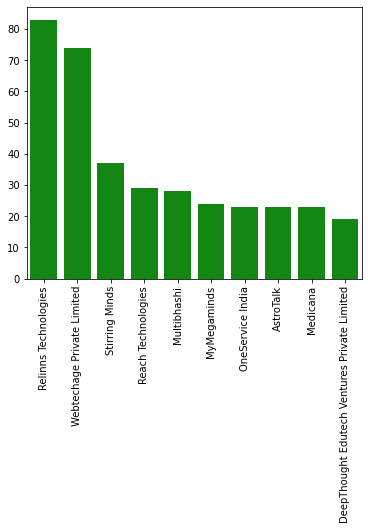

In [54]:
# Top 10 most hiring companies
plt.figure(figsize=(6,5))
sns.barplot(x=df1["Company"].value_counts()[0:10].index, y=df1["Company"].value_counts()[0:10].values, color="#009900")
plt.xticks(rotation=90)

<AxesSubplot:>

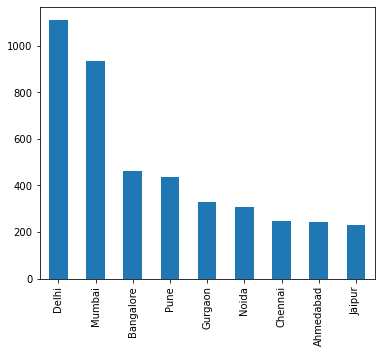

In [55]:
# Top locations with most internships
plt.figure(figsize=(6,5))
df1["Location"].value_counts()[1:10].plot(kind="bar")

<AxesSubplot:>

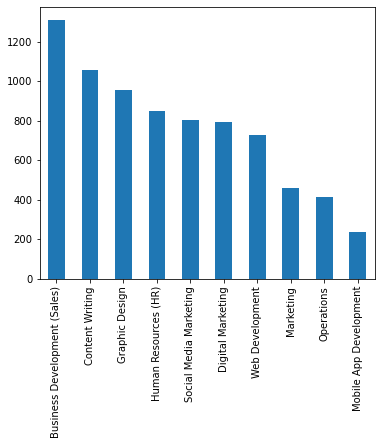

In [56]:
# Top 10 titles for internships
plt.figure(figsize=(6,5))
df1["Title"].value_counts()[0:10].plot(kind="bar")

<AxesSubplot:>

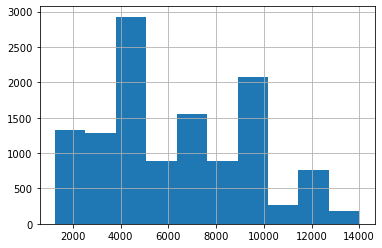

In [52]:
#Checking the distribution of our target variable after removing outliers
df1["Stipend"].hist()

* Barely a normal distribution
* IMP :The poor distribution also signifies that our model will have high error margin but we will try to make it work just enough to give a rough estimate to users.

#### Model building and testing:

In [57]:
#created dummy columns for our leftover categorical variables
df_dum = pd.get_dummies(df1[["Title", "Location"]], drop_first=True)

In [58]:
#dropped the categorical variables
df1.drop(["Title", "Location", "Company"], axis=1, inplace=True)

In [59]:
#concatenated the categorical dummies with main dataframe
df_full = pd.concat([df1, df_dum], axis=1)

In [60]:
#defined the training data and target variable
X = df_full.drop(columns=["Stipend"])
y = df_full["Stipend"]

In [67]:
#imported the required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [68]:
#scaled the training data for optimal training as there were values in non uniform ranges
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
#splitted the data into training set and test set to evaluate model performance and check for overfitting issues if arises
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)

In [70]:
# we define a function to get all ML models we want to test on
def models_to_test():
    models = dict()
    models['LinearRegression'] = LinearRegression()
    models['LassoRegression'] = Lasso()
    models['RidgeRegression'] = Ridge()
    models['SVR'] = SVR()
    models['KNeighborsRegressor'] = KNeighborsRegressor()
    models['DecisionTree'] = DecisionTreeRegressor()
    models['RandomForest'] = RandomForestRegressor()
    models['GradientBoosting'] = GradientBoostingRegressor()
    models['LGBMRegressor'] = LGBMRegressor()
    models['XGBRegressor'] = XGBRegressor()
    return models

In [71]:
# we define a function to evaluate our model on cross val score
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', n_jobs=-1, error_score='raise')
    return scores

In [72]:
# we check the stats of all our vanilla models for shortlisting
models=models_to_test()
results,names=list(),list()

for name,model in models.items():
    scores=evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(">> "+ str(name),"-->","CV Score:", np.round(np.mean(scores), 3),"|","STD:", np.round(np.std(scores), 3))

>> LinearRegression --> CV Score: -5567898944989.314 | STD: 4797742435939.334
>> LassoRegression --> CV Score: -2320.652 | STD: 51.372
>> RidgeRegression --> CV Score: -2341.094 | STD: 60.742
>> SVR --> CV Score: -2594.49 | STD: 41.491
>> KNeighborsRegressor --> CV Score: -2461.913 | STD: 38.627
>> DecisionTree --> CV Score: -2913.266 | STD: 61.885
>> RandomForest --> CV Score: -2320.998 | STD: 53.159
>> GradientBoosting --> CV Score: -2334.205 | STD: 45.056
>> LGBMRegressor --> CV Score: -2286.824 | STD: 48.004
>> XGBRegressor --> CV Score: -2296.273 | STD: 45.081


In [74]:
# we decide to go with LGBM model as it requires less computation resources compared to other shortlisted models and also performing good.
# we try to optimize our model further by hypertuning

parameters= {
    "num_leaves": [15, 20, 25, 32, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125],
    "max_depth": [-1, 2, 3, 4, 5, 8, 10, 12, 15],
    "learning_rate": [0.005, 0.001, 0.0015, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5],
    "max_bin": [255, 125, 355, 500, 700, 55],
    "num_iterations": [10, 50, 75, 100, 150, 200, 500, 1000, 1500],
    "path_smooth": [1,2,3,4,5,10,15,20,25]
}

rclf = RandomizedSearchCV(estimator=LGBMRegressor(num_threads=4), param_distributions= parameters, scoring="neg_mean_absolute_error", verbose=10, n_iter=100, error_score="raise")
rclf.fit(X_train, y_train)
scores = evaluate_model(rclf.best_estimator_, X_train, y_train)
print(">>","CV Score:", np.round(np.mean(scores), 3),"|","STD:", np.round(np.std(scores), 3))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START learning_rate=0.005, max_bin=500, max_depth=2, num_iterations=500, num_leaves=15, path_smooth=2
[CV 1/5; 1/100] END learning_rate=0.005, max_bin=500, max_depth=2, num_iterations=500, num_leaves=15, path_smooth=2;, score=-2401.744 total time=   0.5s
[CV 2/5; 1/100] START learning_rate=0.005, max_bin=500, max_depth=2, num_iterations=500, num_leaves=15, path_smooth=2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[CV 2/5; 1/100] END learning_rate=0.005, max_bin=500, max_depth=2, num_iterations=500, num_leaves=15, path_smooth=2;, score=-2457.246 total time=   0.5s
[CV 3/5; 1/100] START learning_rate=0.005, max_bin=500, max_depth=2, num_iterations=500, num_leaves=15, path_smooth=2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[CV 3/5; 1/100] END learning_rate=0.005, max_bin=500, max_depth=2, num_iteratio

In [77]:
# we save the model, scaler and feature names dictionary for our flask api
import pickle
pickle.dump(rclf.best_estimator_, open('flask-app\internshala_lgbm_model.pkl', 'wb'))
pickle.dump(scaler, open('flask-app\scaler.pkl','wb'))
index_dict = dict(zip(X.columns,range(X.shape[1])))
pickle.dump(index_dict, open('flask-app\index_dict.pkl', 'wb'))

### We conclude till here, next we proceed to flask api for productionising the model.